<a href="https://colab.research.google.com/github/Romilsonlonan/previsao_de_demanda/blob/main/horti_bd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREVISÃO DE DEMANDA 

In [ ]:
!pip install pystan==2.19.1.1 Prophet -q

In [ ]:
!pip install fbprophet -q

In [29]:
# Bíbliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
from holidays import WEEKEND, HolidayBase
from dateutil.easter import easter
from dateutil.relativedelta import relativedelta as rd
import seaborn as sns
import pandas.util.testing as tm
import plotly.express as px
import plotly.graph_objects as go 
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.compat as lzip
from scipy import stats
import scipy.stats as stats



In [ ]:
#Criar variável / importar e ler todo o arquivo
df = pd.read_excel("/content/Dados.xlsx")
df.head(46)

Data  Vendas
0  2022-12-06     870
1  2022-12-07     868
2  2022-12-08    1189
3  2022-12-09     742
4  2022-12-10     317
5  2022-12-11     685
6  2022-12-12    1366
7  2022-12-13    1213
8  2022-12-14    1055
9  2022-12-15    1343
10 2022-12-16     832
11 2022-12-17     240
12 2022-12-18     235
13 2022-12-19    1050
14 2022-12-20     711
15 2022-12-21     745
16 2022-12-22    1009
17 2022-12-23      18
18 2022-12-24      40
19 2022-12-25      67
20 2022-12-26     821
21 2022-12-27     572
22 2022-12-28     429
23 2022-12-29     638
24 2022-12-30     106
25 2022-12-31      54
26 2023-01-01     144
27 2023-01-02     814
28 2023-01-03     679
29 2023-01-04     712
30 2023-01-05    1229
31 2023-01-06     821
32 2023-01-07     319
33 2023-01-08     317
34 2023-01-09    1317
35 2023-01-10     807
36 2023-01-11     923
37 2023-01-12    1265
38 2023-01-13     892
39 2023-01-14     289
40 2023-01-15     566
41 2023-01-16    1692
42 2023-01-17    1097
43 2023-01-18    1302
44 2023-01-19    1405
45 2023-01-20     945

In [ ]:
# Quantidades de linhas e colunas
df.shape

(46, 2)

In [ ]:
# Informação do arquivo
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    46 non-null     datetime64[ns]
 1   Vendas  46 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 864.0 bytes


In [ ]:
# Total de vendas 
# sum(dados["Vendas"])
df["Vendas"].sum()

34750

In [ ]:
# propriedades estatísticas mais importantes
df.describe()

Vendas
count    46.000000
mean    755.434783
std     430.762201
min      18.000000
25%     346.500000
50%     810.500000
75%    1053.750000
max    1692.000000

MEDIDAS DE TENDENCIA CENTRAL 

É uma medida de valores numa amostra que identifica os diferentes pontos centrais nos dados, muitas vezes referidos coloquialmente como “médias”. As medidas mais comuns de tendência central são a média, a mediana e a moda.

In [ ]:
# média de vendas
df['Vendas'].median()

810.5

In [ ]:
df['Vendas'].mean()

755.4347826086956

In [ ]:
# Vendas com os mesmo valor
df['Vendas'].mode()

0    317
1    821
dtype: int64

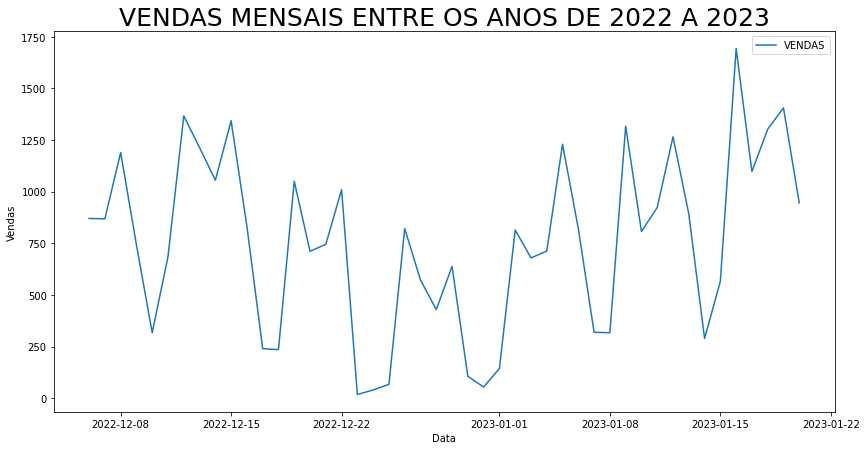

In [ ]:
# Visualizando como os dados se comportam
#plt.scatter(dados['Data'], dados['Vendas'])
plt.figure(figsize=(14, 7))
plt.title("VENDAS MENSAIS ENTRE OS ANOS DE 2022 A 2023", fontsize = 25)
plt.plot(df.Data, df.Vendas, label='VENDAS')
plt.ylabel("Vendas")
plt.xlabel("Data")
plt.legend()

plt.show()

MEDIDAS DE DISPERSÃO 

As medidas de dispersão são usadas para obter o grau de variabilidade dos elementos de um conjunto de informações. Amplitude e desvio são os mais fundamentais desses cálculos.

In [ ]:
""" 
Medida de Dispersão Mínima é quando todos os valores de uma amostra são iguais, o desvio padrão é igual a 0. 
Sendo que, quanto mais próximo de 0, menor é a dispersão dos dados.
"""
df['Vendas'].min()

18

In [ ]:
""" 
Medida de Dispersão Máxima é o desvio padrão é uma medida que só pode assumir valores não negativos e quanto 
maior for, maior será a dispersão dos dados. Quanto maior for a variabilidade entre os dados, maior será o 
desvio padrão.
"""
df['Vendas'].max()

1692

In [ ]:
"""
Medida de dispersão variança, dado um conjunto de dados, a variância é uma medida de dispersão que mostra o quão 
distante cada valor desse conjunto está do valor central (médio). Quanto menor é a variância, mais próximos os 
valores estão da média; mas quanto maior ela é, mais os valores estão distantes da média.
"""
df['Vendas'].var()

185556.0734299517

In [ ]:
"""
Medida de Disperção Desvio Padrão, é o desvio padrão indica o grau de dispersão de um conjunto de dados, 
ou seja, o quanto ele é uniforme. Quanto menor for o desvio padrão, mais homogêneos são os dados. A 
vantagem de usarmos o desvio padrão (ao invés da variância), é que essa medida é expressa na mesma unidade 
dos dados, o que facilita a comparação e seu uso.
""" 
df['Vendas'].std()

430.7622005584423

TESTE DE HIPÓTESE

É uma metodologia estatística que nos auxilia a tomar decisões sobre uma ou mais populações baseado na informação obtida da amostra. Nos permite verificar se os dados amostrais trazem evidência que apoiem ou não uma hipótese estatística formulada.

Teste de normalidade (Shapiro-Wilk):

A hipótese nula do teste de Shapiro-Wilk é que a população possui distribuição normal. Portanto, um valor de p < 0.05 indica que você rejeitou a hipótese nula, ou seja, seus dados não possuem distribuição normal.

In [ ]:
"""
O teste de Shapiro & Wilk (1965) é possivelmente o teste mais utilizado para verificar se um determinado 
conjunto de dados independentes segue a distribuição Normal. 
"""

stats.shapiro(df['Vendas'])


ShapiroResult(statistic=0.9656936526298523, pvalue=0.1904204785823822)

In [ ]:
stats.normaltest(df.Vendas)

NormaltestResult(statistic=2.3120412518125972, pvalue=0.31473614505759584)

In [ ]:
# Fazendo o Teste de Normalidade com estrutura de decisão if e else

alpha = 0.05
k2, p = stats.normaltest(df['Vendas'])

if p < alpha:
    print("A Hipótese Nula pode ser rejeitada")
else:
    print("A hipótese nula não pode ser rejeitada")


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


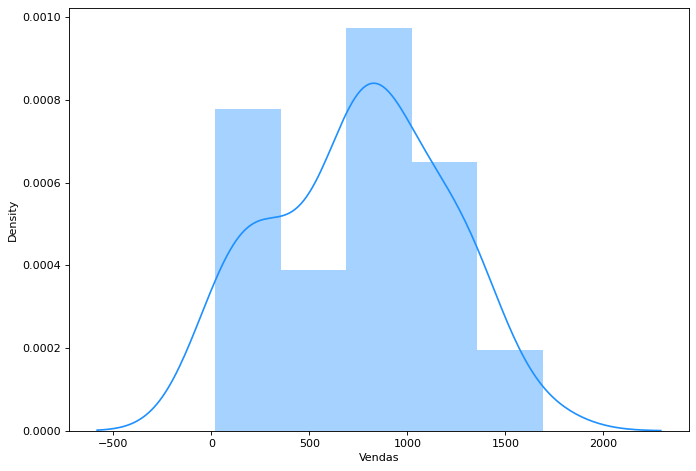

In [ ]:
# Visualizando os dados após os teste

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(df['Vendas'], color="dodgerblue", label="Compact")

plt.show()

SERIE TEMPORAL E ANALISE PREDITIVA

Uma série temporal é simplesmente uma série de pontos de dados ordenados no tempo. Em uma série temporal, o tempo costuma ser a variável independente e a meta geralmente é fazer uma previsão para o futuro

In [ ]:
# A coluna ds receberá os valores das datas e a coluna “y” o valor numérico a ser previsto
serie_temporal = pd.read_excel('/content/Dados.xlsx', parse_dates = ['Data'], index_col = 0, squeeze = True)
serie_temporal.head()

Data
2022-12-06     870
2022-12-07     868
2022-12-08    1189
2022-12-09     742
2022-12-10     317
Name: Vendas, dtype: int64

In [ ]:
# alterando o nome das colunas e salvar isso em um novo dataframe
# A função “.tail(12)” irá retornar as últimas 12 linhas do dataframe
df = pd.DataFrame({'ds': serie_temporal.index, 'y': serie_temporal.values})
df.tail(12)

ds     y
34 2023-01-09  1317
35 2023-01-10   807
36 2023-01-11   923
37 2023-01-12  1265
38 2023-01-13   892
39 2023-01-14   289
40 2023-01-15   566
41 2023-01-16  1692
42 2023-01-17  1097
43 2023-01-18  1302
44 2023-01-19  1405
45 2023-01-20   945

In [ ]:
# criar um dataframe chamado teste com os últimos 12 meses e um dataframe chamado treino com os dados restantes
treino = df[:34]
teste = df[34:] 

('DataFrame de Treino: {}, entradas \nDataFrame de Testes: {} entradas.'.format(len(treino), len(teste)))

'DataFrame de Treino: 34, entradas \nDataFrame de Testes: 12 entradas.'

In [ ]:
# fazer um fit(treinamento) do nosso modelo
# Nosso modelo foi treinado somente com o parâmetro de sazonalidade “seasonality_mode” igual a “multiplicative”. 
# Usamos este parâmetro caso tenhamos uma sazonalidade crescente ao longo do tempo
modelo = Prophet(seasonality_mode = 'multiplicative')
modelo.fit(treino)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# novo chamado “df_previsoes” usando o dataframe “teste”
df_previsoes = pd.DataFrame({'ds' : teste['ds'].values})
df_previsoes

ds
0  2023-01-09
1  2023-01-10
2  2023-01-11
3  2023-01-12
4  2023-01-13
5  2023-01-14
6  2023-01-15
7  2023-01-16
8  2023-01-17
9  2023-01-18
10 2023-01-19
11 2023-01-20

In [ ]:
# Usando o “df_previsoes” para treinar o modelo e salvamos as previsões na variável “pred”
pred = modelo.predict(df_previsoes)

As previsões do FbProphet retornam um dataframe com várias colunas

yhat = valor médio previsto

yhat_upper = maior valor previsto

yhat_lower = menor valor previsto

In [ ]:
# Chamar o dataframe “pred” somente com as colunas que nos interessam
pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

ds        yhat  yhat_lower  yhat_upper
0  2023-01-09  726.610890  474.561929  997.463117
1  2023-01-10  540.803834  289.658917  816.478818
2  2023-01-11  504.603748  224.240328  772.067074
3  2023-01-12  699.732243  441.858289  952.965708
4  2023-01-13  327.003404   46.220886  576.604655
5  2023-01-14  124.215914 -126.232465  401.486960
6  2023-01-15  191.829496  -64.510057  460.398342
7  2023-01-16  608.147534  320.524999  881.384903
8  2023-01-17  450.531098  147.366536  718.270394
9  2023-01-18  418.316015  173.309118  686.117256
10 2023-01-19  577.081139  310.198957  845.724858
11 2023-01-20  268.213163   -9.069197  557.600983

In [ ]:
# Prevendo novos dados
# Prevendo os dados para os próximos 5 dias.
# treinar nosso modelo com todos os dados:
modelo = Prophet(seasonality_mode='multiplicative')
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Criando um dataframe chamado futuro
futuro = modelo.make_future_dataframe(periods = 5, freq = 'D')
futuro.tail(5)


ds
46 2023-01-21
47 2023-01-22
48 2023-01-23
49 2023-01-24
50 2023-01-25

In [ ]:
# Prevendo novos dados conforme dataframe chamado futuro
pred = modelo.predict(futuro)
pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds         yhat  yhat_lower   yhat_upper
46 2023-01-21   233.991351  -97.906254   559.673281
47 2023-01-22   372.805572   50.485040   689.400419
48 2023-01-23  1316.723728  981.797499  1619.532834
49 2023-01-24   958.847095  650.132193  1269.672518
50 2023-01-25   978.394624  652.270279  1303.910165

Text(53.625, 0.5, 'Valores de Vendas')

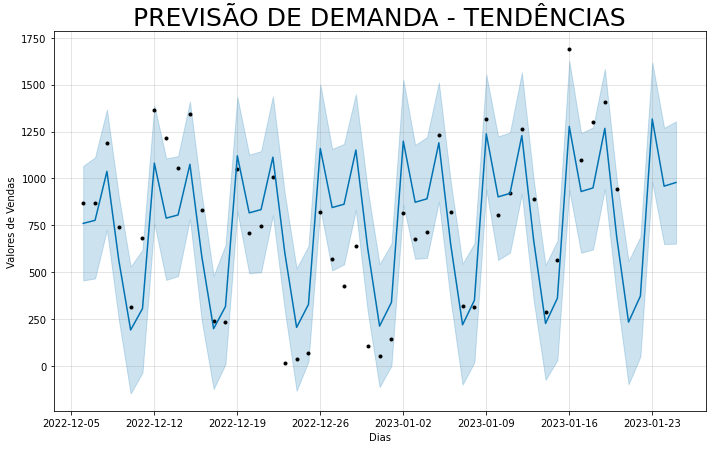

In [ ]:
# Visualizando as tendências 
fig = modelo.plot(pred)
plt.title('PREVISÃO DE DEMANDA - TENDÊNCIAS', fontsize = 25)
plt.xlabel('Dias', fontsize = 10)
plt.ylabel('Valores de Vendas', fontsize = 10)

# Nova seção

1.   Item da lista
2.   Item da lista



# Nova seção